In [26]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  #data visualization library
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix  # evaluation metrics

ef = pd.read_excel('Algerian_forest_fires_dataset_UPDATE.xlsx')
ef.columns =['d','m','y','Temp','RH','Ws','Rain','FFMC','DMC','DC','ISI','BUI','FWI','Label']
ef = ef.iloc[1: , :]
ef = ef.drop(columns=['ISI','BUI','FWI'])
ef = pd.concat([ef.iloc[0: 122], ef.iloc[125:]], ignore_index=True)

for a in range(0, len(ef)):
    element = str(ef.iloc[a]["Label"])
    ef.iloc[a]["Label"] = element.strip()
    woutLabel = ef.iloc[:, ef.columns!='Label']
    for k in range(len(ef.columns) - 1):
        #print("row: " + str(a) + "  " + str(woutLabel.iloc[a][k]))
        woutLabel.iloc[a][k] = int(woutLabel.iloc[a][k])

ef['Label'] = np.where(ef['Label']=='not fire', '0', '1')
y = ef['Label'].to_numpy()
tf = ef.loc[ : , ef.columns!='Label']
scaler = StandardScaler()
mean_normalized_df = scaler.fit_transform(tf)
new_df = pd.DataFrame(mean_normalized_df, columns=tf.columns)

#244 data points
#50/16/16/16 split into training/featureSelection/testing/validation
training = new_df.iloc[0:122]
y_training = y[0:122]
fselect = new_df.iloc[122:163]
y_fselect = y[122:163]
testing = new_df.iloc[163:203]
y_testing = y[163:203]
validation = new_df.iloc[203:]
y_validation = y[203:]


In [39]:
#feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.svm import SVR

feature_number = 1
treeClass = ExtraTreesClassifier(n_estimators=50)
treeClass.fit(fselect, y_fselect)
treeModel = RFE(SVR(kernel="linear"), n_features_to_select=feature_number, step=1)
treeModel = treeModel.fit(fselect, y_fselect)

combined_array = np.vstack(([np.round(treeClass.feature_importances_, 2)], [treeModel.support_]))
testingdf = pd.DataFrame(combined_array, columns=tf.columns)
print(testingdf)

treeClassifierFeatureImportanceWeight = testingdf.loc[0]
treeSelected = treeClassifierFeatureImportanceWeight.sort_values(ascending=False).index[:feature_number]
treeClassifierSelected = testingdf[treeSelected]
print(treeClassifierSelected)
RFE_ranking = testingdf.loc[1]
RFE_selected = RFE_ranking.sort_values(ascending=False).index[:feature_number]
RFE_good = testingdf[RFE_selected]
print(RFE_good)


      d     m    y  Temp    RH    Ws  Rain  FFMC   DMC    DC
0  0.05  0.03  0.0   0.1  0.05  0.02  0.08  0.26  0.21  0.21
1  0.00  0.00  0.0   0.0  0.00  0.00  0.00  0.00  0.00  1.00
   FFMC
0  0.26
1  0.00
     DC
0  0.21
1  1.00


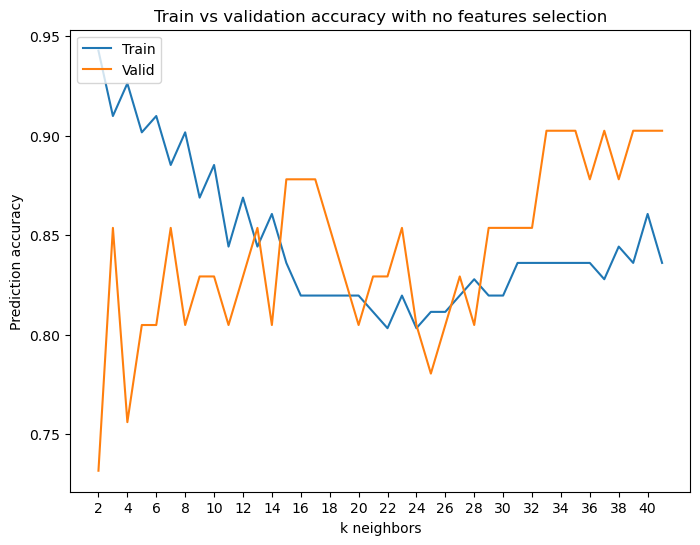

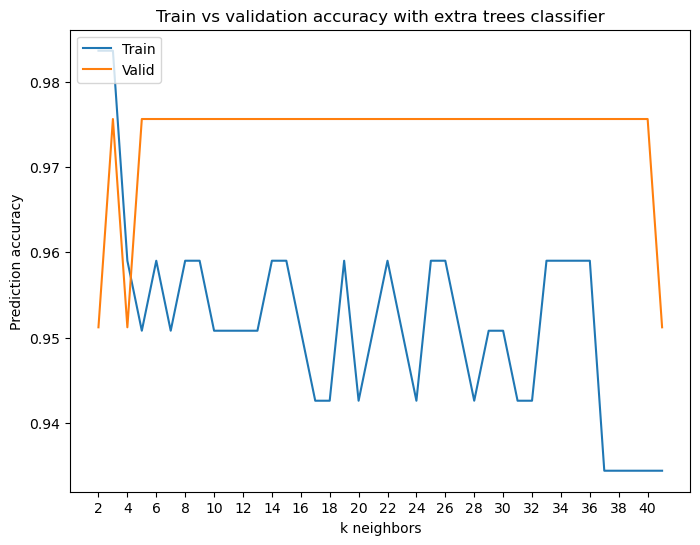

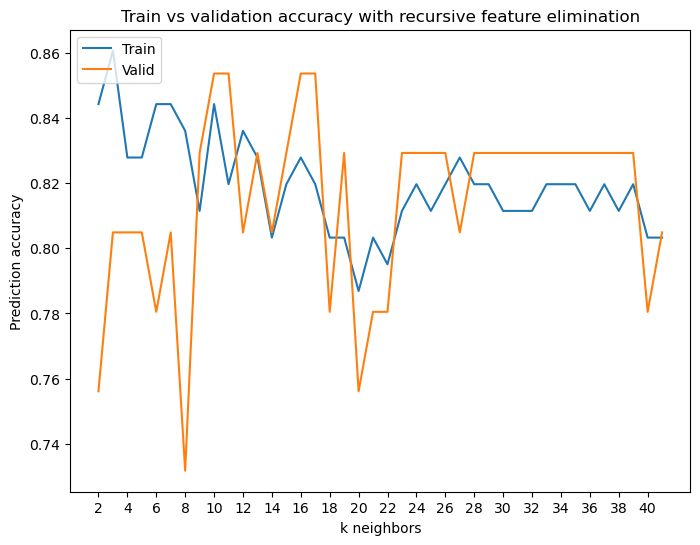

Avg validation accuracy of k=2 to 42 with no features selection: 0.8426829268292687
Avg validation accuracy of k=2 to 42 with extra trees classifier : 0.9737804878048786
Avg validation accuracy of k=2 to 42 with recursive feature elimination: 0.814634146341463
Chosen features selection: Extra Trees Classifier, KNN with k=20
model ACCURACY with testing set: 1.0
model PRECISION with testing set: 1.0
model RECALL with testing set: 1.0
model F1 SCORE with testing set: 1.0


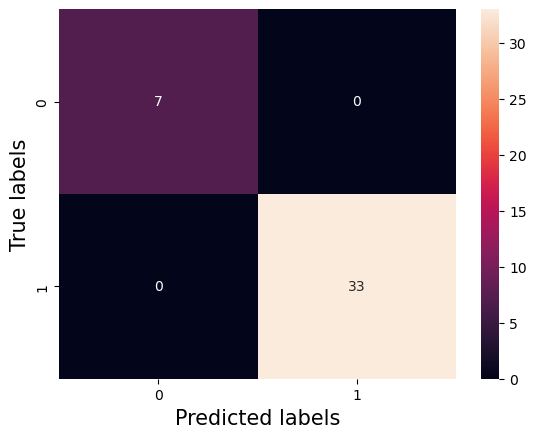

In [40]:
#KNN part without feature selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
def knn(up, to, t, v, fselect_type, plot):
    neighbors = list(range(up, to))
    t_acc = []
    v_acc = []
    for n in range(len(neighbors)):
        neigh = KNeighborsClassifier(n_neighbors=neighbors[n])
        neigh.fit(t, y_training)
        t_acc.append(accuracy_score(y_training, neigh.predict(t)))
        v_acc.append(accuracy_score(y_validation, neigh.predict(v)))
    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(neighbors, t_acc, label = 'Train')
        plt.plot(neighbors, v_acc, label = 'Valid')
        plt.xticks(neighbors[::2])
        plt.legend(loc = 'upper left')
        plt.xlabel('k neighbors')
        plt.ylabel('Prediction accuracy')
        plt.title('Train vs validation accuracy with '+ fselect_type)
        plt.show()
    return t_acc, v_acc
width = 40
all_features = knn(2, 2+width, training, validation, "no features selection", True)
etc_features = knn(2, 2+width, training[treeSelected], validation[treeSelected], "extra trees classifier", True)
rfe_features = knn(2, 2+width, training[RFE_selected], validation[RFE_selected], "recursive feature elimination", True)
print("Avg validation accuracy of k=2 to 42 with no features selection: " + str( sum(all_features[1][0:width])/(width) ))
print("Avg validation accuracy of k=2 to 42 with extra trees classifier : " + str( sum(etc_features[1][0:width])/(width) ))
print("Avg validation accuracy of k=2 to 42 with recursive feature elimination: " + str( sum(rfe_features[1][0:width])/(width) ))
print("Chosen features selection: Extra Trees Classifier, " + "KNN with k=" + str(20))
neigh = KNeighborsClassifier(n_neighbors = 20 )
neigh.fit(training[treeSelected], y_training)
y_pred = neigh.predict(testing[treeSelected])
confmat = confusion_matrix(y_testing, y_pred)
print("model ACCURACY with testing set: "+str(accuracy_score(y_testing, y_pred)))
precision = confmat[1][1] / (confmat[1][1] + confmat[0][1])
recall = confmat[1][1] / (confmat[1][1] + confmat[1][0])
print("model PRECISION with testing set: " + str(precision))
print("model RECALL with testing set: " + str(recall))
print("model F1 SCORE with testing set: " + str( (2 * precision * recall) / (precision + recall)))
ax = plt.subplot()
sns.heatmap(confmat,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
plt.show()

0.9672131147540983


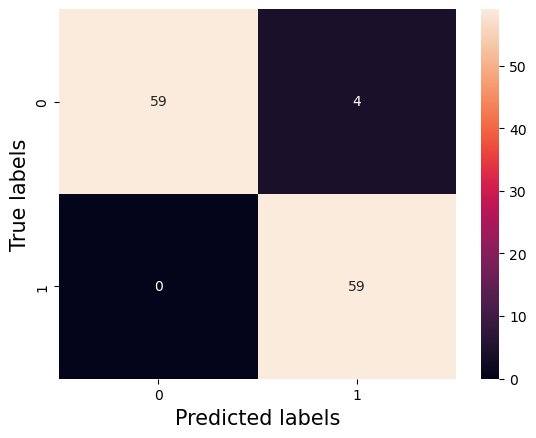

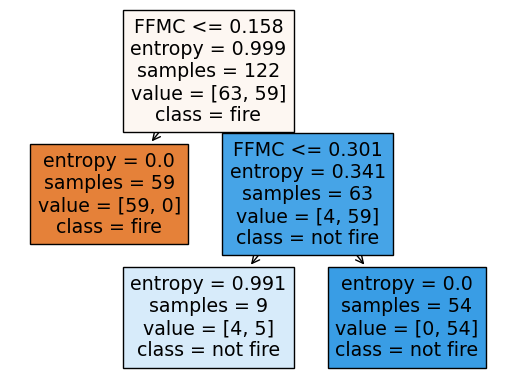

In [42]:
from sklearn.tree import export_text, plot_tree, DecisionTreeClassifier, export_graphviz
#decision tree



clf = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=2)
clf_all = clf.fit(training, y_training)
y_testing_pred = clf_all.predict(training)
acc = accuracy_score(y_training, y_testing_pred)
print(acc)
confmat = confusion_matrix(y_training, y_testing_pred)

ax = plt.subplot()
sns.heatmap(confmat,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
plt.show()
plot_tree(clf_all, feature_names = list(tf.columns),  filled = True, class_names=["fire", "not fire"])
plt.show()



1.0
1.0
0.8536585365853658
Testing accuracy with all features : 1.0
Testing accuracy with ETC features : 1.0
Testing accuracy with RFE features: 0.875
model PRECISION with testing set: 0.9117647058823529
model RECALL with testing set: 0.9393939393939394
model F1 SCORE with testing set: 0.9253731343283583


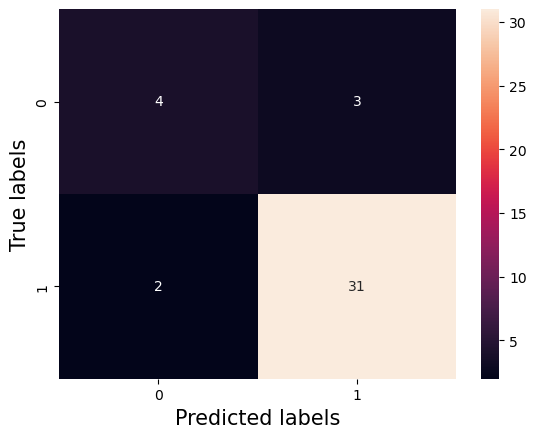

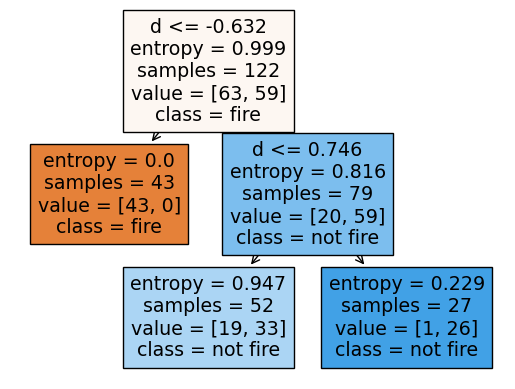

In [43]:
from sklearn.tree import export_text, plot_tree, DecisionTreeClassifier, export_graphviz
#decision tree



clf = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=2)
clf_all = clf.fit(training, y_training)
y_testing_pred = clf_all.predict(testing)
acc_all = accuracy_score(y_testing, y_testing_pred)
acc = accuracy_score(y_validation, clf_all.predict(validation))
print(acc)

clf_etc = clf.fit(training[treeSelected], y_training)
y_testing_pred = clf_etc.predict(testing[treeSelected])
acc_etc = accuracy_score(y_testing, y_testing_pred)
acc = accuracy_score(y_validation, clf_etc.predict(validation[treeSelected]))
print(acc)


clf_rfe = clf.fit(training[RFE_selected], y_training)
y_testing_pred = clf_rfe.predict(testing[RFE_selected])
acc_rfe = accuracy_score(y_testing, y_testing_pred)
acc = accuracy_score(y_validation, clf_rfe.predict(validation[RFE_selected]))
print(acc)

confmat = confusion_matrix(y_testing, y_testing_pred)
print("Testing accuracy with all features : " + str(acc_all))
print("Testing accuracy with ETC features : " + str(acc_etc))
print("Testing accuracy with RFE features: " + str(acc_rfe))
precision = confmat[1][1] / (confmat[1][1] + confmat[0][1])
recall = confmat[1][1] / (confmat[1][1] + confmat[1][0])
print("model PRECISION with testing set: " + str(precision))
print("model RECALL with testing set: " + str(recall))
print("model F1 SCORE with testing set: " + str( (2 * precision * recall) / (precision + recall)))

ax = plt.subplot()
sns.heatmap(confmat,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
plt.show()

plot_tree(clf_rfe, feature_names = list(tf.columns),  filled = True, class_names=["fire", "not fire"])
plt.show()

